<a href="https://colab.research.google.com/github/mzaoualim/us_gas_price/blob/main/notebooks/step_by_step_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions
!uv pip install -q xlrd --system

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 115.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import autogluon as ag
from statsmodels.tsa.ar_model import ar_select_order
import xlrd

In [ ]:
# notes
'''
 - 1 - ML/DL folder structure
 - 2 - Steps:
 -> load data (with specs)
 -> preprocessing data
 -> Modeling
 -> Training & Testing & Fine-tuning
 -> Prediction
 -> Evaluation
 -> Save model
 -> Notebook finalization
 -> Streamlit App layout
 -> Deploy Model & App
'''

# Introduction

Data scientist role is to turn:
* Data > Insights > Recommadation > Making Impact on Business




# BUSINESSES UNDERSTANDING

"How does this model or solution directly address our core business objectives?"

In [ ]:
# fuel now or later?
# make decision either to fuel now or later based on tank level and forecasted gas price and historical consumption?
# the  goal is the anticipate the price shocks and optimize fuel-cost purchase


# DATA PREPARATION

"Have we thoroughly cleaned and preprocessed our data to ensure it's of high quality?"

"Are we aware of any anomalies in our data that could impact model performance?"


## Work with real data

 - Streaming Data

 - Real time, user produced Data

 - Data updated frequently

##Work with modern technologies
	@Work with APIs
	  - Learn use, configure and setup APIs (Tokens)
	  - Learn use libraries to make API calls
      - Work with Data structures (JSON, Dictionaries...)
	  -> Collect/Retrieve Data
	@Databases in the cloud
	  - Store (pre/processed) Data in DB
	  - Learn use Cloud services (AWS, GC...)


In [4]:
# load data
data = pd.read_excel(
    'https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMR_PTE_NUS_DPGw.xls',
    sheet_name='Data 1',
    skiprows=2
)
data.head()

,Date,Weekly U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)
0,1990-08-20,1.191
1,1990-08-27,1.245
2,1990-09-03,1.242
3,1990-09-10,1.252
4,1990-09-17,1.266


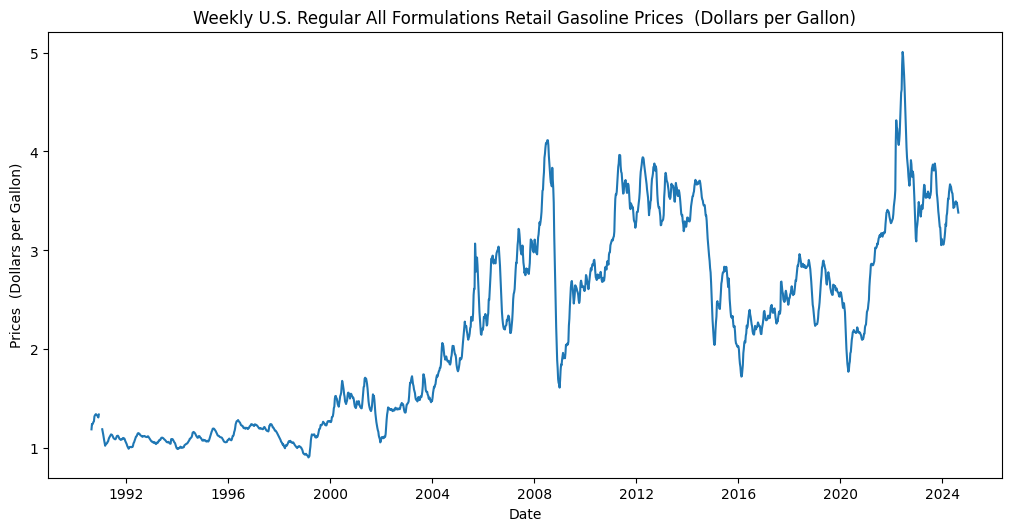

In [ ]:
# plot the prices vs Dates
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Date', ascending=True)

plt.title('Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)')
plt.xlabel('Date')
plt.ylabel('Prices  (Dollars per Gallon)')

plt.plot(df_sorted['Date'],
         df_sorted['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)'])

# FEATURE ENGINEERING

"Have we Build super strong features using transformations and Machine learning methods for dimensionality Reduction?"


In [ ]:
## lags with log transformation
df_lags = data.copy()
df_lags.set_index('Date', inplace=True)

mod = ar_select_order(np.log(df_lags['Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)']),
                      trend='ct',
                      glob=True,
                      missing='drop',
                      # seasonal=True,
                      maxlag=12)

print('Significant log transformed price lags: ', mod.ar_lags)
del df_lags

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Significant log transformed price lags:  [1, 2, 4, 8]


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [5]:
# formating data according to AutoGluon specs
data_ag = data.copy()
data_ag['item_id'] = 'Gas_Price'

data_ag.rename(columns={'Date':'timestamp',
                   'Weekly U.S. Regular All Formulations Retail Gasoline Prices  (Dollars per Gallon)':'target'},
          inplace=True)

data_ag['target'] = np.log(data_ag['target'])

# adding lagged cols
lags = [1, 2, 4, 8]
for lag in lags:
    data_ag['target_lag_' + str(lag)] = data_ag.target.shift(lag)

#  finding the best rolling mean

def find_best_window(data, window_range):
  best_window = None
  best_error = float('inf')

  for window in window_range:
    rolling_mean = data.rolling(window=window).mean()
    error = np.mean(abs(data - rolling_mean))
    if error < best_error:
      best_error = error
      best_window = window

  return best_window

best_window = find_best_window(data_ag['target'], range(53))
data_ag[f'rolling_mean_{best_window}'] = data_ag['target'].rolling(best_window).mean()

# deleting NaN values
data_ag.dropna(inplace=True)

data_ag.head()

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674


# MODELING

"Have we compared different models supervised unsupervised or semi supervised?"

"Have we used AutoML?"

Using AutoGluon, an AutoML framework to compare multiple models + an ensemble solution.

![image.png](attachment:bafc7e28-4896-40e2-80d4-0bdc55778b01.png)

In [ ]:
# https://auto.gluon.ai/0.7.0/tutorials/timeseries/forecasting-indepth.html#what-is-probabilistic-time-series-forecasting

In [ ]:
# experimenting with chronos
# https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html
# https://github.com/amazon-science/chronos-forecasting

##Building Models:

	@Start with Kaggle thought process
	@Understanding decision making choices
	@Questions to Answer:
	  - Why did you pick your model?
	  -> What are you trying to accomplish with this model that you couldn't do with another model.
	  - How did you clean your Data?
        - What type of validation tests did you perform on the Data to prepare it for the model?
	  - Tell me about the assumption of your model?
	  -> How did you validate these assumption?
	  - How did you optimize your model?
	  -> What are the trade-off decision that you've made?
	  - How did you implement your test/control?
	  - Tell me about how the underlying math in the model works?
	  - Model perfomance?
	@Goal> Thought Process and how the decision is made

## AutoGluon with minimal config

In [ ]:
data_ag

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674
...,...,...,...,...,...,...,...,...
1770,2024-07-22,1.244443,Gas_Price,1.251619,1.249615,1.234890,1.274524,1.244443
1771,2024-07-29,1.248181,Gas_Price,1.244443,1.251619,1.246745,1.257324,1.248181
1772,2024-08-05,1.237794,Gas_Price,1.248181,1.244443,1.249615,1.232269,1.237794
1773,2024-08-12,1.227885,Gas_Price,1.237794,1.248181,1.251619,1.234017,1.227885


In [ ]:
# loading formated data
train_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[:-52],
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target  target_lag_1  target_lag_2  target_lag_4  \
item_id   timestamp                                                        
Gas_Price 1990-10-15  0.291923      0.287432      0.278389      0.235862   
          1990-10-22  0.296394      0.291923      0.287432      0.240590   
          1990-10-29  0.291923      0.296394      0.291923      0.278389   
          1990-11-05  0.288182      0.291923      0.296394      0.287432   
          1990-11-12  0.283674      0.288182      0.291923      0.291923   

                      target_lag_8  rolling_mean_1  
item_id   timestamp                                 
Gas_Price 1990-10-15      0.174793        0.291923  
          1990-10-22      0.219136        0.296394  
          1990-10-29      0.216723        0.291923  
          1990-11-05      0.224742        0.288182  
          1990-11-12      0.235862        0.283674

In [ ]:
predictor = TimeSeriesPredictor(
    freq='W',
    prediction_length=52,
    path="us_gas",
    target="target",
    eval_metric="sMAPE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=2400,
)

Frequency 'W' stored as 'W-SUN'
Beginning AutoGluon training... Time limit = 2400s
AutoGluon will save models to 'us_gas'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
GPU Count:          1
Memory Avail:       29.80 GB / 31.36 GB (95.0%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'W-SUN',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 52,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 2400,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to f

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.1018       = Validation score (-SMAPE)
	22.80   s     = Training runtime
	2.98    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 550.4s of the 2201.5s of remaining time.
	-0.0881       = Validation score (-SMAPE)
	211.54  s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 695.0s of the 1989.9s of remaining time.
	-0.0783       = Validation score (-SMAPE)
	177.60  s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 1212.0s of the 1812.0s of remaining time.
	-0.0705       = Validation score (-SMAPE)
	57.53   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'DeepAR': 0.01, 'PatchTST': 0.66, 'TemporalFusionTransformer': 0.33}
	-0.0547       = Validation score (-SMAPE)
	4.73    s     = Training 

data with frequency 'None' has been resampled to frequency 'W-SUN'.
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


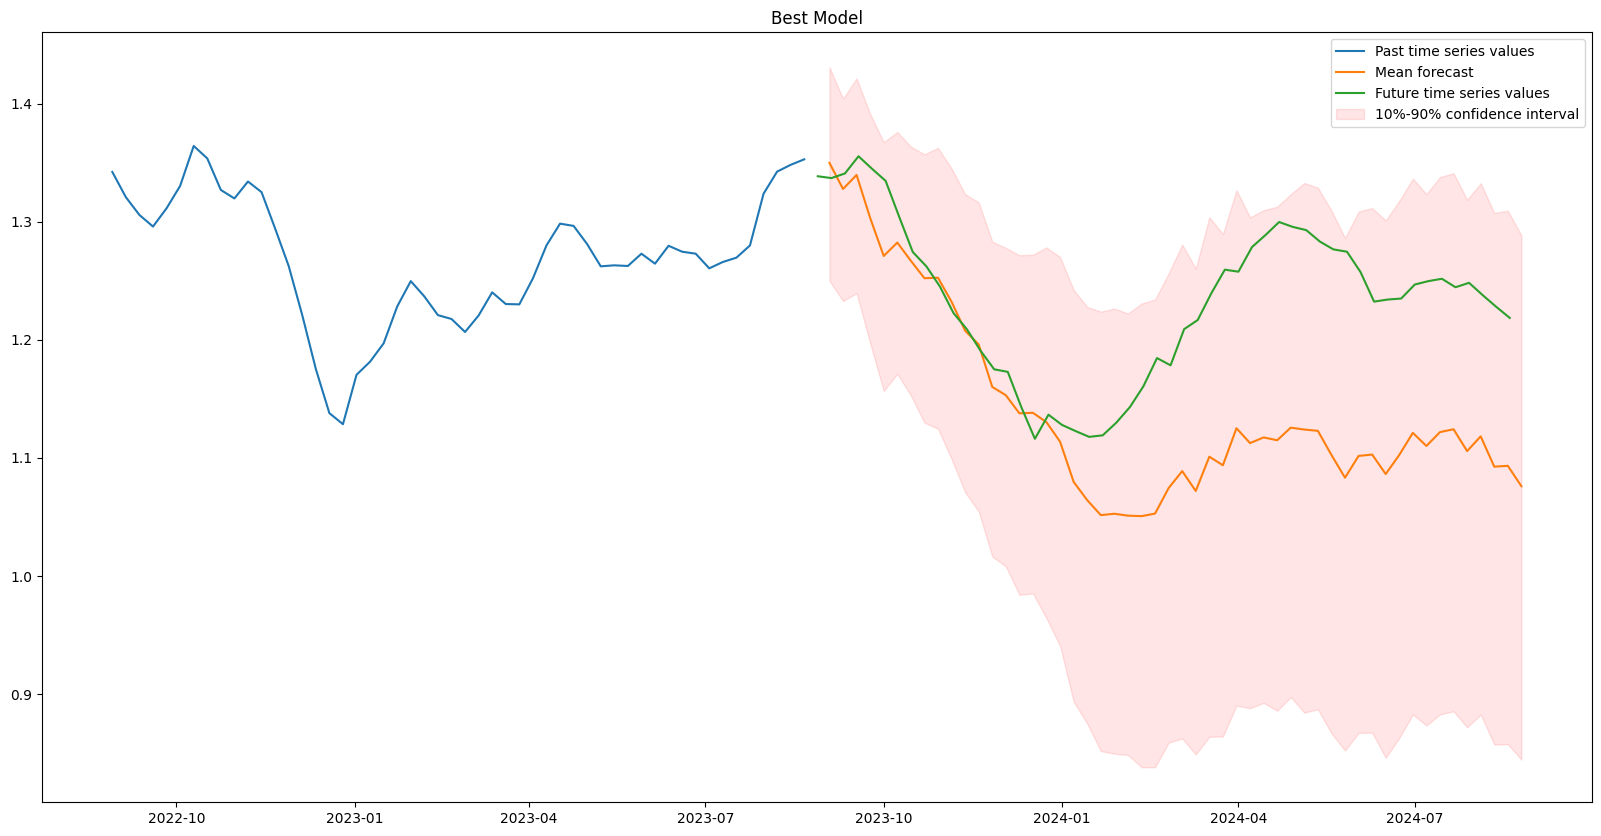

In [ ]:
predictions = predictor.predict(train_data)

test_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]#[-52:]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Best Model')
plt.legend();

# MODEL PERFORMANCE

"Have we explored various models and performed hyperparameter tuning to ensure optimal performance?"

"Do we have a benchmark or baseline model performance for comparison?"

In [ ]:
# Model leaderboard (all_data)
predictor.leaderboard(data_ag)

data with frequency 'None' has been resampled to frequency 'W-SUN'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,PatchTST,-0.043237,-0.070502,0.059842,0.024621,57.532088,12
1,CrostonSBA,-0.044124,-0.155768,13.159941,10.736736,13.335341,4
2,DirectTabular,-0.051282,-0.169077,0.109102,0.105054,2.600267,3
3,Chronos[base],-0.063406,-0.101844,3.065364,2.981894,22.803437,9
4,WeightedEnsemble,-0.079558,-0.054743,0.492870,0.377856,4.733662,13
5,DynamicOptimizedTheta,-0.088105,-0.106551,15.584424,24.329168,24.704998,6
6,AutoETS,-0.093695,-0.106031,31.521192,14.585971,14.964496,7
7,SeasonalNaive,-0.093695,-0.106031,0.027675,1.699983,2.178803,1
8,AutoARIMA,-0.098226,-0.102947,17.631580,17.257748,17.455178,8
9,RecursiveTabular,-0.106452,-0.106160,1.141765,1.001978,20.227167,2


data with frequency 'None' has been resampled to frequency 'W-SUN'.
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


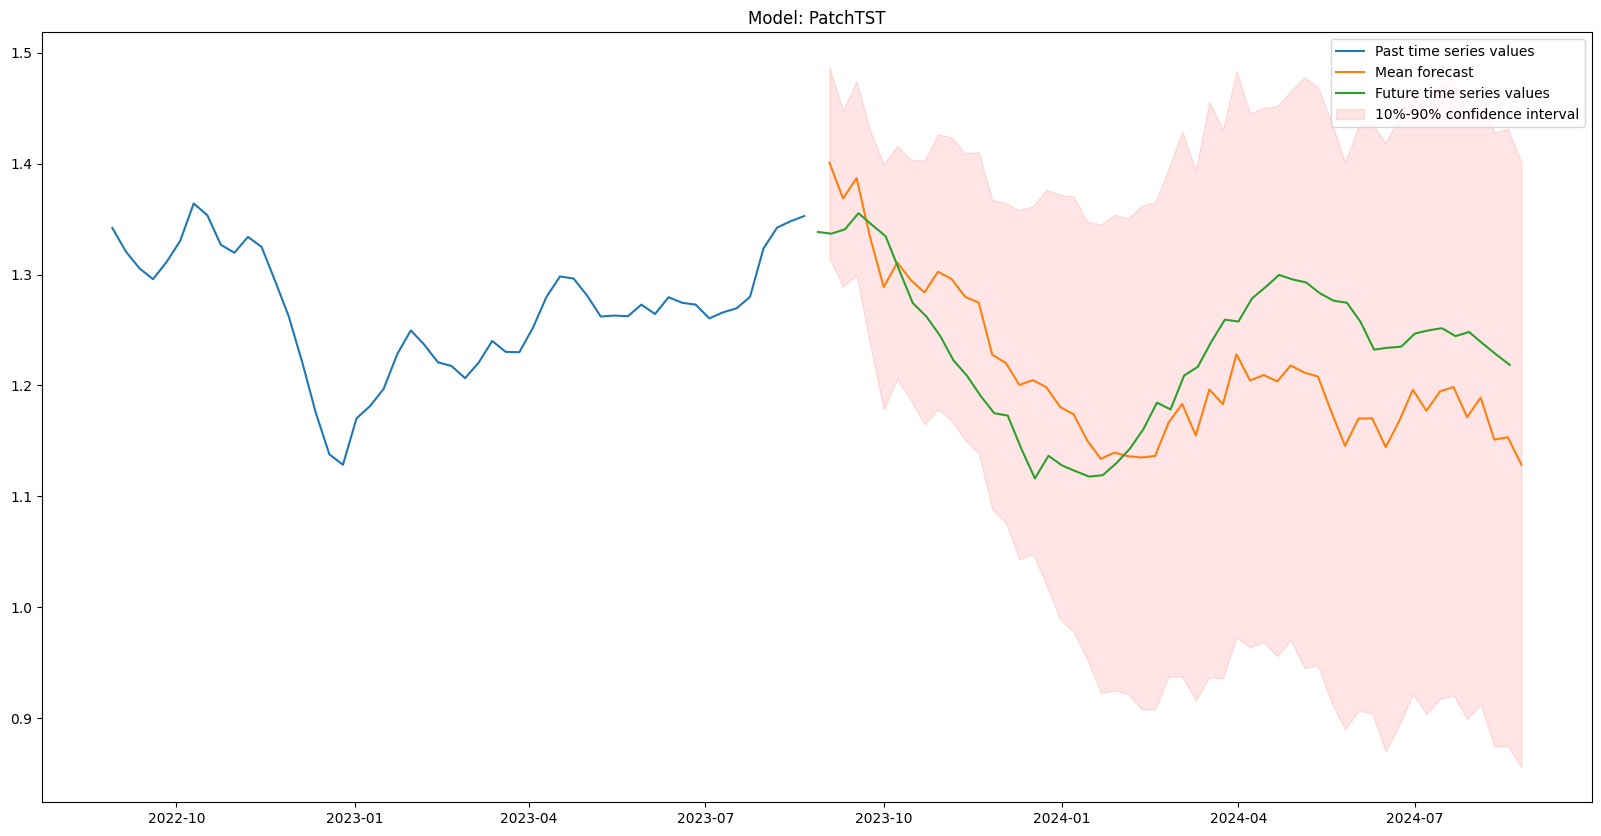

In [ ]:
predictions = predictor.predict(train_data, model='PatchTST')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Model: PatchTST')
plt.legend();

data with frequency 'None' has been resampled to frequency 'W-SUN'.


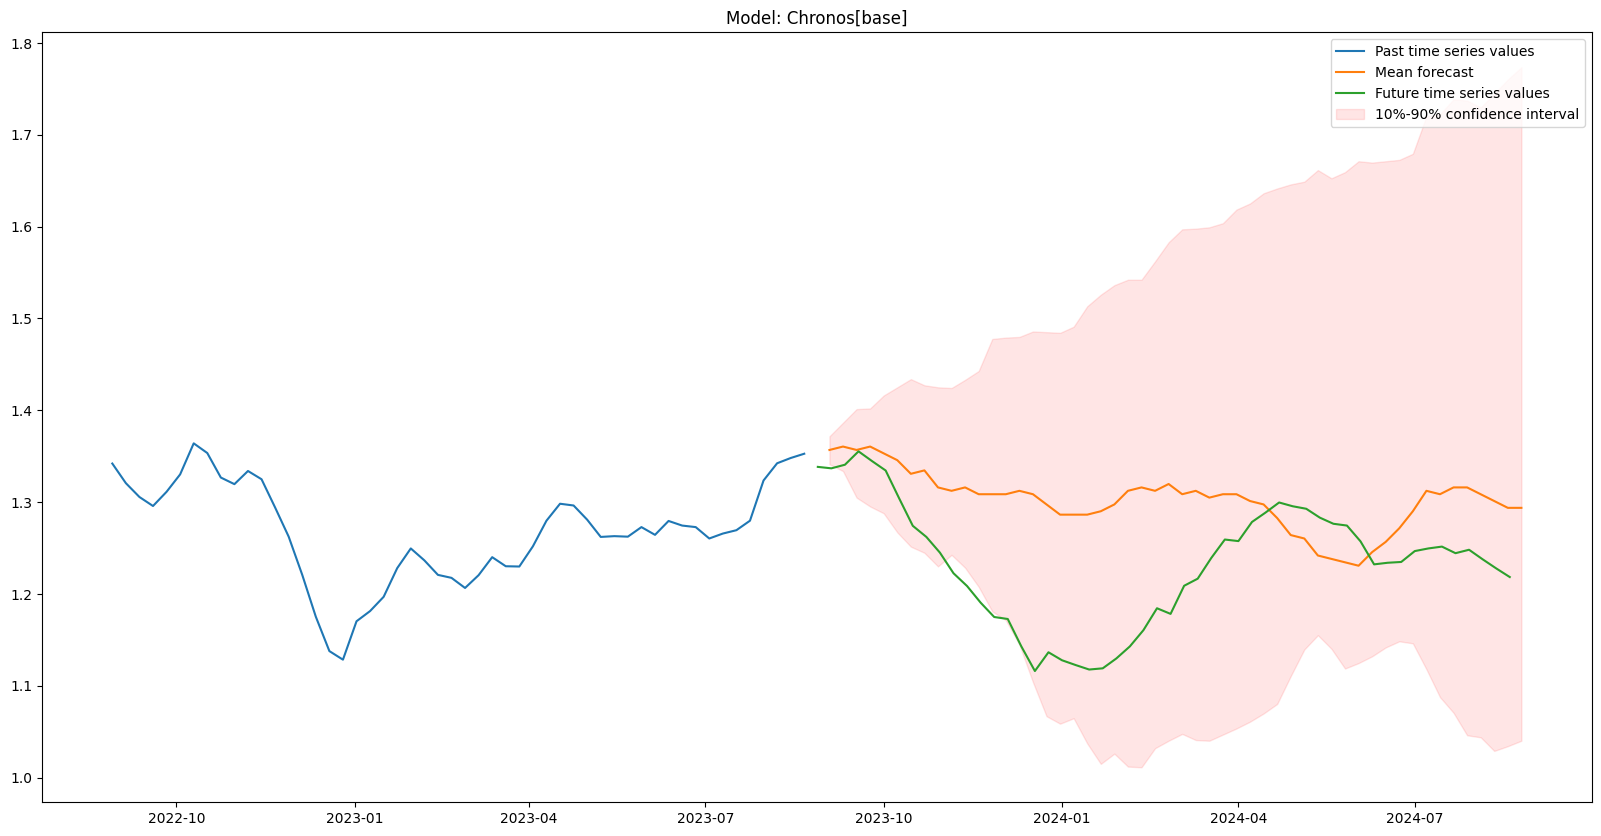

In [ ]:
predictions = predictor.predict(train_data, model='Chronos[base]')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Model: Chronos[base]')
plt.legend();

# MODEL FINE TUNNING

"Have we used Hyperparameter tunning with Bayesian Search?"


## AutoGluon with manual&hyper param config



In [ ]:
data_ag.head()

,timestamp,target,item_id,target_lag_1,target_lag_2,target_lag_4,target_lag_8,rolling_mean_1
8,1990-10-15,0.291923,Gas_Price,0.287432,0.278389,0.235862,0.174793,0.291923
9,1990-10-22,0.296394,Gas_Price,0.291923,0.287432,0.240590,0.219136,0.296394
10,1990-10-29,0.291923,Gas_Price,0.296394,0.291923,0.278389,0.216723,0.291923
11,1990-11-05,0.288182,Gas_Price,0.291923,0.296394,0.287432,0.224742,0.288182
12,1990-11-12,0.283674,Gas_Price,0.288182,0.291923,0.291923,0.235862,0.283674


In [ ]:
predictor_tuned = TimeSeriesPredictor(
    freq='W-MON',
    prediction_length=52,
    path="us_gas_tuned",
    target="target",
    eval_metric="sMAPE",
)

predictor_tuned.fit(
    data_ag[:-52],
    hyperparameters={
        "PatchTST": {
            "context_length" : ag.common.space.Int(5, 36),
            "patch_len": ag.common.space.Int(4, 32),
            "stride": ag.common.space.Int(4, 32),
            "d_model": ag.common.space.Int(4, 128),
            "nhead": ag.common.space.Int(2, 64),
            "dim_feedforward": ag.common.space.Int(2, 32),
            "dropout": ag.common.space.Categorical(0.1, 0.3),
            "lr": ag.common.space.Real(1e-5, 1e-2, log=True),
            "batch_size": ag.common.space.Int(8, 128),
        },

        "Chronos": {
            "model_path": "large",
            "batch_size": ag.common.space.Int(8, 128),
            "device": "auto",
        }
    },
    hyperparameter_tune_kwargs="auto",
    enable_ensemble=True,
    time_limit=2400,
)

	Trained 6 models while tuning PatchTST.
	-0.0387       = Validation score (-SMAPE)
	959.26  s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[large]/T10': 0.08,
 'Chronos[large]/T116': 0.11,
 'Chronos[large]/T118': 0.12,
 'Chronos[large]/T18': 0.08,
 'Chronos[large]/T3': 0.12,
 'Chronos[large]/T52': 0.12,
 'Chronos[large]/T62': 0.25,
 'Chronos[large]/T67': 0.01,
 'Chronos[large]/T95': 0.11,
 'PatchTST/2836003e': 0.01}
	-0.0211       = Validation score (-SMAPE)
	20.83   s     = Training runtime
	60.59   s     = Validation (prediction) runtime
Training complete. Models trained: ['Chronos[large]/T1', 'Chronos[large]/T2', 'Chronos[large]/T3', 'Chronos[large]/T4', 'Chronos[large]/T5', 'Chronos[large]/T6', 'Chronos[large]/T7', 'Chronos[large]/T8', 'Chronos[large]/T9', 'Chronos[large]/T10', 'Chronos[large]/T11', 'Chronos[large]/T12', 'Chronos[large]/T13', 'Chronos[large]/T14', 'Chronos[large]/T15', 'Chronos[large]/T16', 'Chronos[large]/T17', 'Chronos[la

In [ ]:
predictor_tuned.leaderboard(data_ag)

data with frequency 'None' has been resampled to frequency 'W-MON'.
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos[large]/T63,-0.034924,-0.042445,6.812931,6.785386,6.796562,63
1,PatchTST/53e328f8,-0.036916,-0.040652,0.043356,0.021886,41.820592,126
2,Chronos[large]/T11,-0.045570,-0.073019,6.870830,6.699838,6.710150,11
3,Chronos[large]/T103,-0.046833,-0.103271,6.891385,6.708964,6.718658,103
4,PatchTST/df98b6fe,-0.047814,-0.047153,0.051246,0.023571,53.190032,127
...,...,...,...,...,...,...,...
123,Chronos[large]/T64,-0.093690,-0.049089,6.922693,6.898607,6.910081,64
124,Chronos[large]/T3,-0.099253,-0.032841,6.831300,6.820288,6.830332,3
125,Chronos[large]/T6,-0.099463,-0.030124,6.815973,6.742185,6.751765,6
126,Chronos[large]/T100,-0.109667,-0.048160,6.857515,6.806967,6.817832,100


data with frequency 'None' has been resampled to frequency 'W-MON'.
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


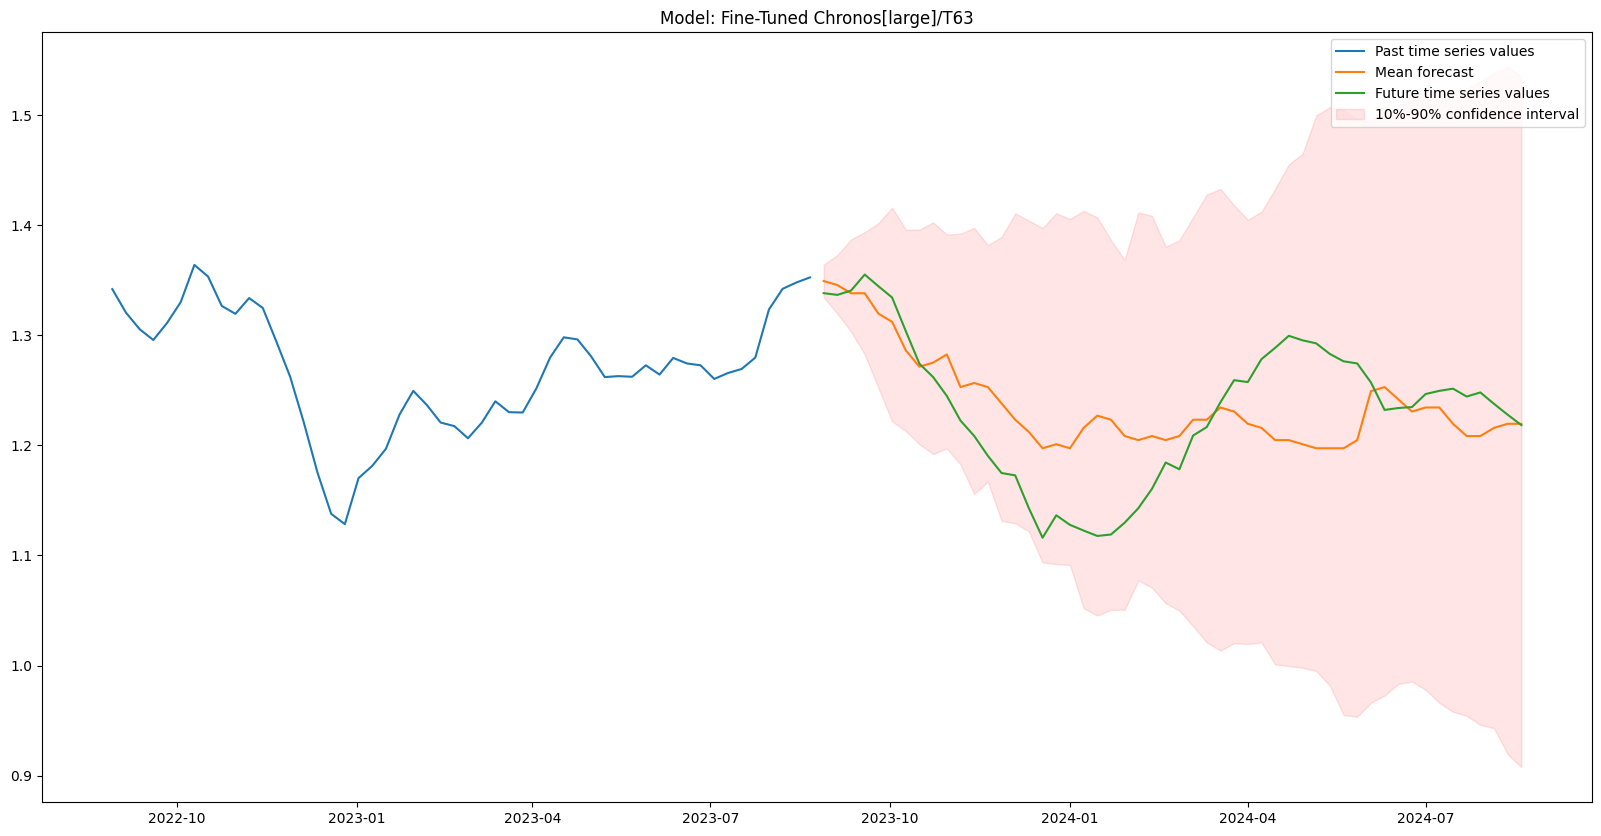

In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[:-52],
    id_column="item_id",
    timestamp_column="timestamp"
)

test_data = TimeSeriesDataFrame.from_data_frame(
    data_ag[-52:],
    id_column="item_id",
    timestamp_column="timestamp"
)

predictions = predictor_tuned.predict(train_data, model='Chronos[large]/T63')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Model: Fine-Tuned Chronos[large]/T63')
plt.legend();

data with frequency 'None' has been resampled to frequency 'W-MON'.


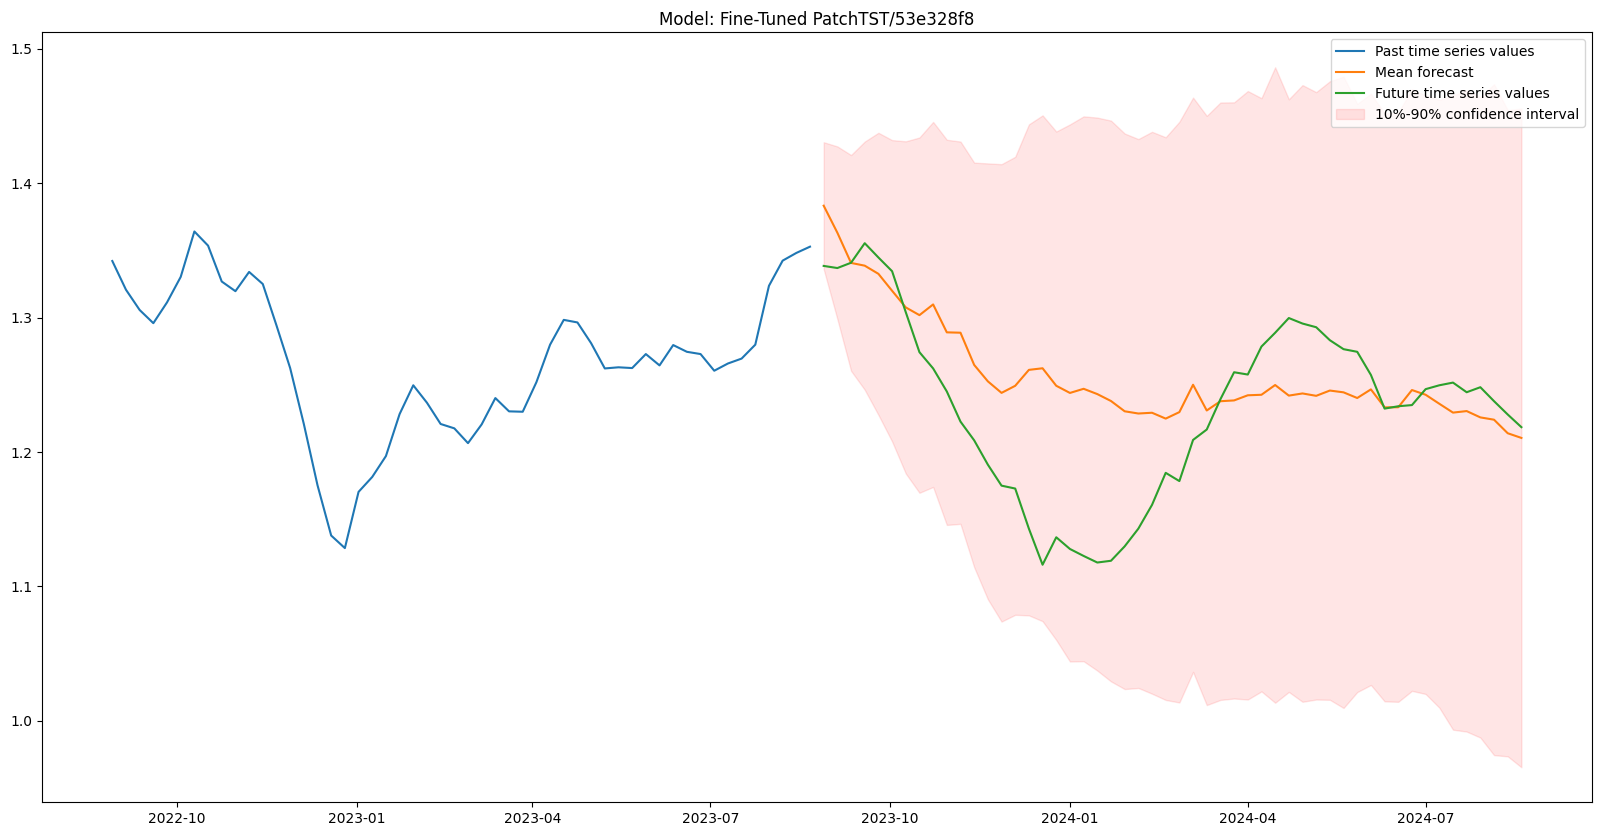

In [ ]:
predictions = predictor_tuned.predict(train_data, model='PatchTST/53e328f8')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Model: Fine-Tuned PatchTST/53e328f8')
plt.legend();

data with frequency 'None' has been resampled to frequency 'W-MON'.


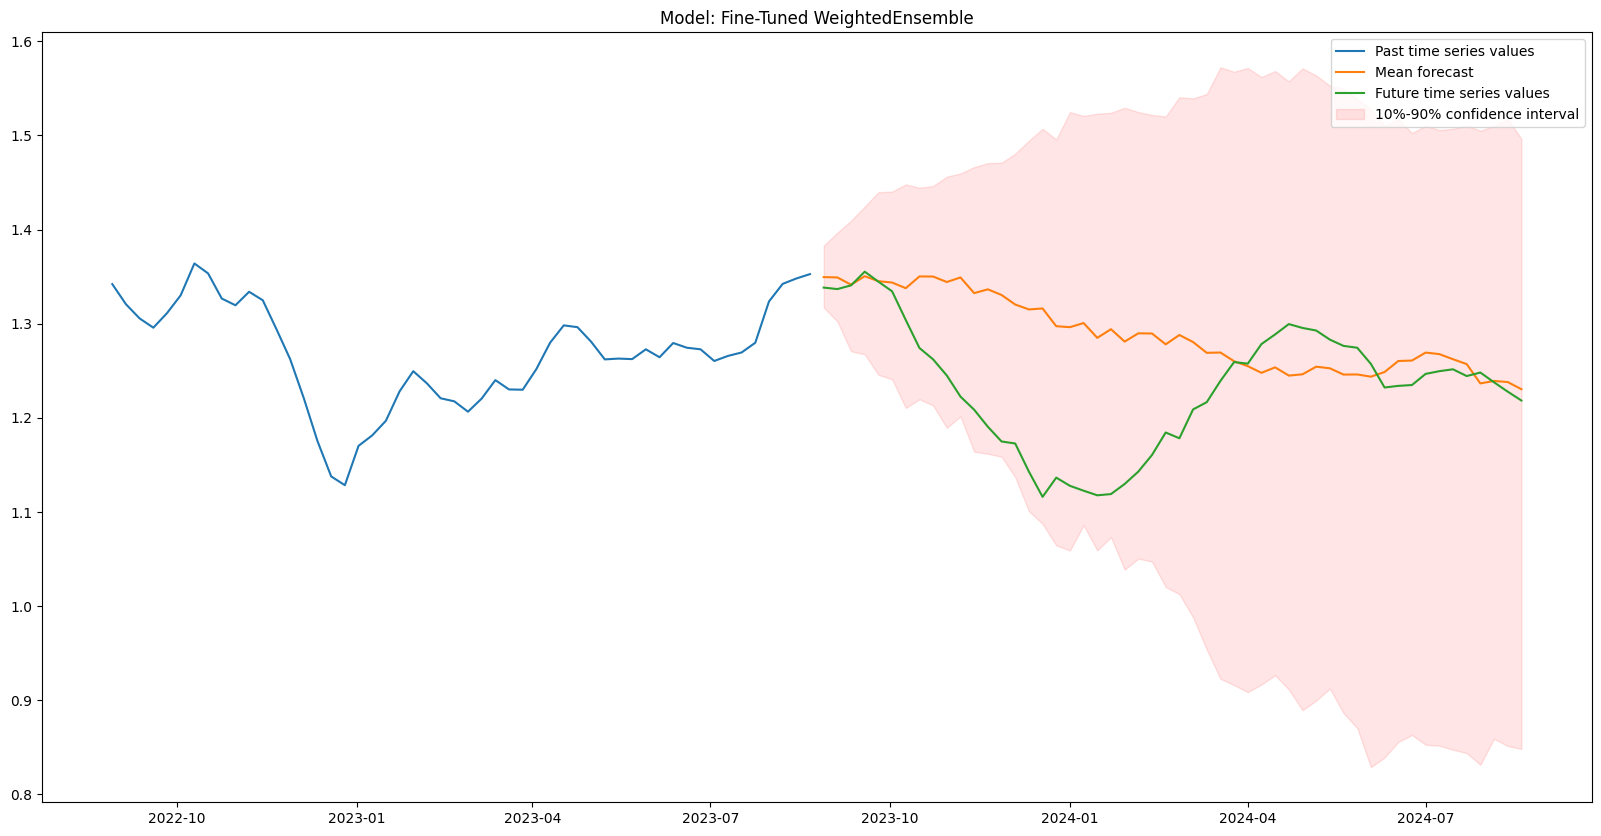

In [ ]:
predictions = predictor_tuned.predict(train_data, model='WeightedEnsemble')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_past = train_data.loc[item_id]["target"][-52:]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.title('Model: Fine-Tuned WeightedEnsemble')
plt.legend();

In [ ]:
# saving models

!zip -r us_gas_tuned.zip '/kaggle/working/us_gas_tuned'

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/us_gas_tuned/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/learner.pkl (deflated 63%)
  adding: kaggle/working/us_gas_tuned/logs/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/logs/predictor_log.txt (deflated 71%)
  adding: kaggle/working/us_gas_tuned/predictor.pkl (deflated 34%)
  adding: kaggle/working/us_gas_tuned/models/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/models/trainer.pkl (deflated 80%)
  adding: kaggle/working/us_gas_tuned/models/cached_predictions.pkl (deflated 72%)
  adding: kaggle/working/us_gas_tuned/models/WeightedEnsemble/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/models/WeightedEnsemble/model.pkl (deflated 51%)
  adding: kaggle/working/us_gas_tuned/models/Chronos[large]/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/W0/ (stored 0%)
  adding: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/W0/model.pkl (de

#8. DEPLOYMENT

"Is our model designed with deployment in mind, considering integration and operational needs?"

/content/us_gas_tuned##Making an impact / Getting validation

	@Share code with DS community
	  - Git repo...
	@Publish finding
	  - Create visualization
	  -> Article/Blog...
	@Turn it into useful App
	  - Learn Application framework
	  - django, Flask...
	  - Deploy an application in the cloud
	  -> AWS, GC...
	  - Example
	  -> Interactive DashBoard, API...


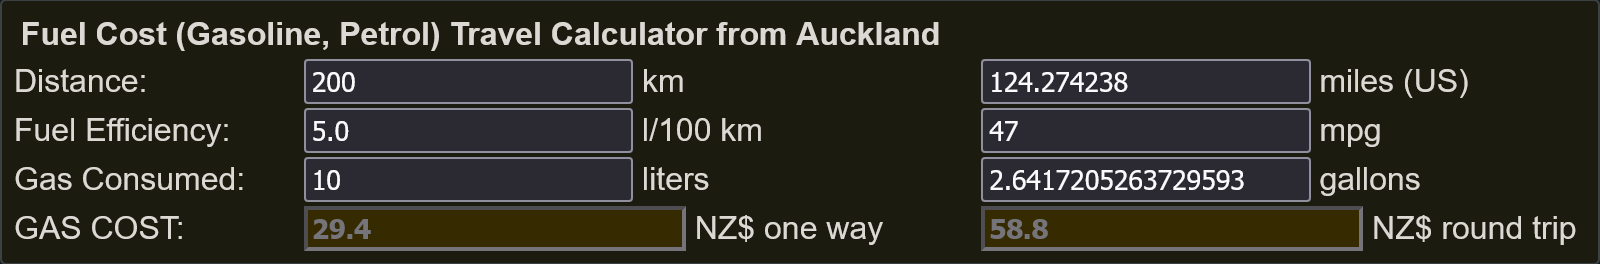

In [ ]:
'''
 - Using GitHub actions as a free and serverless computing power to run code on a schedule
 -> CI/CD pipeline
'''

In [3]:
# unzip model
!unzip '/content/us_gas_tuned.zip'

Archive:  /content/us_gas_tuned.zip
   creating: kaggle/working/us_gas_tuned/
  inflating: kaggle/working/us_gas_tuned/learner.pkl  
   creating: kaggle/working/us_gas_tuned/logs/
  inflating: kaggle/working/us_gas_tuned/logs/predictor_log.txt  
  inflating: kaggle/working/us_gas_tuned/predictor.pkl  
   creating: kaggle/working/us_gas_tuned/models/
  inflating: kaggle/working/us_gas_tuned/models/trainer.pkl  
  inflating: kaggle/working/us_gas_tuned/models/cached_predictions.pkl  
   creating: kaggle/working/us_gas_tuned/models/WeightedEnsemble/
  inflating: kaggle/working/us_gas_tuned/models/WeightedEnsemble/model.pkl  
   creating: kaggle/working/us_gas_tuned/models/Chronos[large]/
   creating: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/
   creating: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/W0/
  inflating: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/W0/model.pkl  
  inflating: kaggle/working/us_gas_tuned/models/Chronos[large]/T80/model.pkl  
   cre

In [6]:
# loading best model
weighted_Ensemble_Model = TimeSeriesPredictor.load('/content/kaggle/working/us_gas_tuned')

In [7]:
np.exp(weighted_Ensemble_Model.predict(data_ag, model='WeightedEnsemble')['mean']).plot()

data with frequency 'None' has been resampled to frequency 'W-MON'.


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

mean       0.1       0.2       0.3       0.4  \
item_id   timestamp                                                      
Gas_Price 2024-08-26  1.204157  1.177557  1.183884  1.194953  1.197876   
          2024-09-02  1.183861  1.154151  1.167969  1.178737  1.181435   
          2024-09-09  1.175895  1.124703  1.139479  1.156446  1.164919   
          2024-09-16  1.176927  1.110010  1.122227  1.147214  1.156736   
          2024-09-23  1.165490  1.077699  1.114754  1.126299  1.141307   
          2024-09-30  1.155113  1.053148  1.103217  1.113767  1.130912   
          2024-10-07  1.140118  1.015569  1.074093  1.091477  1.107611   
          2024-10-14  1.147157  1.012434  1.056803  1.091489  1.097846   
          2024-10-21  1.146670  0.991790  1.035464  1.067524  1.103521   
          2024-10-28  1.124667  0.957131  0.998185  1.046625  1.085124   
          2024-11-04  1.122060  0.963905  1.006124  1.036424  1.095431   
          2024-11-11  1.114151  0.949394  0.987871  0.999075  1.066304   
          2024-11-18  1.122689  0.966674  0.984526  0.993748  1.059112   
          2024-11-25  1.114521  0.958436  0.982821  1.021025  1.054334   
          2024-12-02  1.116990  0.938728  0.999238  1.031439  1.058607   
          2024-12-09  1.118104  0.929392  1.009167  1.023811  1.085758   
          2024-12-16  1.124569  0.932596  1.019929  1.034306  1.079965   
          2024-12-23  1.117592  0.925530  1.031403  1.042514  1.058630   
          2024-12-30  1.107829  0.913954  1.019576  1.049092  1.069619   
          2025-01-06  1.106717  0.949029  1.034640  1.073578  1.082590   
          2025-01-13  1.101936  0.945778  1.012318  1.056996  1.078576   
          2025-01-20  1.124746  0.985649  1.016445  1.059344  1.087031   
          2025-01-27  1.114940  0.948173  1.011507  1.035389  1.060790   
          2025-02-03  1.096620  0.989291  1.027598  1.040025  1.066273   
          2025-02-10  1.107743  0.987707  1.038228  1.060638  1.069302   
          2025-02-17  1.113878  0.944102  1.025854  1.056424  1.068499   
          2025-02-24  1.130294  0.934459  1.056892  1.078977  1.100061   
          2025-03-03  1.138657  0.907409  1.049351  1.084939  1.108246   
          2025-03-10  1.135320  0.861963  1.045445  1.098996  1.110730   
          2025-03-17  1.148074  0.840951  1.040441  1.103747  1.130240   
          2025-03-24  1.151595  0.852307  1.054032  1.100275  1.118860   
          2025-03-31  1.153395  0.877629  1.060218  1.102967  1.116699   
          2025-04-07  1.153528  0.919912  1.071219  1.089259  1.115313   
          2025-04-14  1.162199  0.955949  1.053496  1.095814  1.112661   
          2025-04-21  1.153280  0.954804  1.026219  1.093606  1.120667   
          2025-04-28  1.161100  0.891506  1.010217  1.078404  1.122977   
          2025-05-05  1.175568  0.854593  1.016525  1.077393  1.115324   
          2025-05-12  1.175958  0.841376  1.016180  1.068110  1.116635   
          2025-05-19  1.184523  0.828218  0.997537  1.042373  1.105219   
          2025-05-26  1.178442  0.838589  0.989144  1.029516  1.105595   
          2025-06-02  1.158836  0.827597  0.971167  1.017909  1.085311   
          2025-06-09  1.157502  0.850177  0.960066  1.020075  1.063004   
          2025-06-16  1.172050  0.874547  0.951003  1.009312  1.074024   
          2025-06-23  1.186251  0.900970  0.944747  1.003336  1.103688   
          2025-06-30  1.212386  0.882736  0.933050  0.995380  1.100743   
          2025-07-07  1.212332  0.865347  0.938344  0.985649  1.083401   
          2025-07-14  1.218653  0.859027  0.941951  0.987863  1.075577   
          2025-07-21  1.223335  0.871639  0.932223  0.992967  1.054516   
          2025-07-28  1.204687  0.849491  0.905133  0.994114  1.046934   
          2025-08-04  1.210839  0.852805  0.910209  1.021711  1.069598   
          2025-08-11  1.210397  0.854564  0.913899  1.032101  1.100963   
          2025-08-18  1.187795  0.856706  0.911082  1.022083  1.126623   

                           0.

data with frequency 'None' has been resampled to frequency 'W-MON'.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


<Axes: xlabel='item_id,timestamp'>

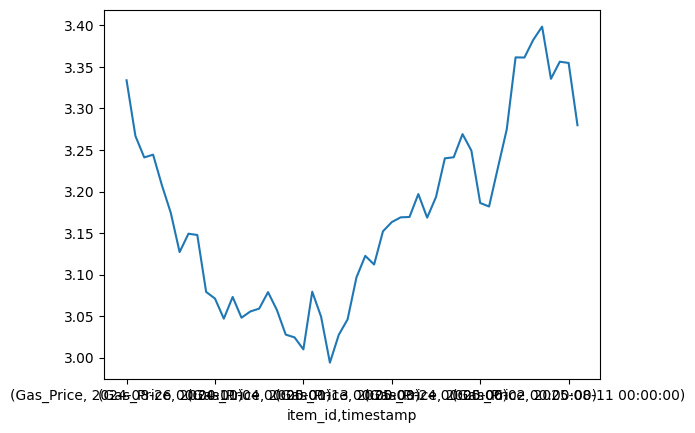

In [8]:
np.exp(weighted_Ensemble_Model.predict(data_ag, model='WeightedEnsemble')['mean']).plot()

data with frequency 'None' has been resampled to frequency 'W-MON'.


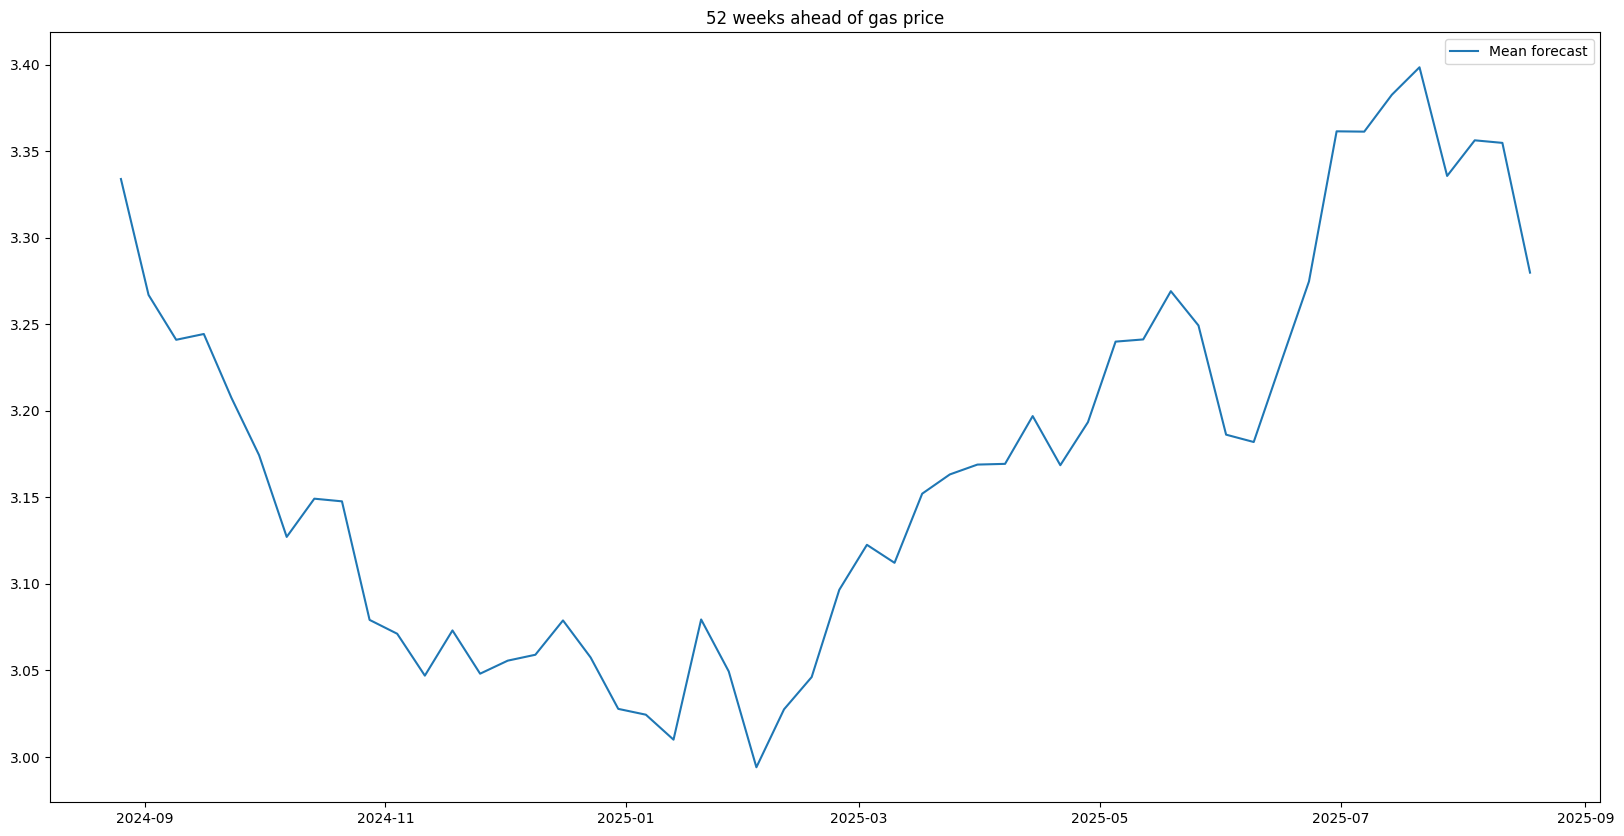

In [10]:
predictions = weighted_Ensemble_Model.predict(data_ag, model='WeightedEnsemble')

plt.figure(figsize=(20, 10))

item_id = "Gas_Price"
y_pred = predictions.loc[item_id]

plt.plot(np.exp(y_pred["mean"]), label="Mean forecast")

# plt.fill_between(
#     y_pred.index, np.exp(y_pred["0.1"]), np.exp(y_pred["0.9"]), color="red", alpha=0.1, label=f"10%-90% confidence interval"
# )
plt.title('52 weeks ahead of gas price')
plt.legend();

#9. AI EXPLAINABILITY

"Can we explain how our model makes decisions in a way that's understandable to non-technical stakeholders?"

#10. MODEL MONITORING

"Are we continuously monitoring model performance and seeking opportunities for improvement?"

#11. AI FAIRNESS

"Have we considered the ethical implications of our data sources and modeling techniques?"

"Have we assessed our model for potential biases against certain groups or individuals?"

"What steps have we taken to mitigate any identified biases in our model?"

# 12. REFERENCES

[Fuel Cost (Gasoline, Petrol) Travel Calculator](https://www.numbeo.com/gas-prices/in/Albany)

[US Gasoline and Diesel Fuel Update](https://www.eia.gov/petroleum/gasdiesel/)

[Chronos: Learning the Language of Time Series](https://github.com/amazon-science/chronos-forecasting)

[Adapting language model architectures for time series forecasting](https://www.amazon.science/blog/adapting-language-model-architectures-for-time-series-forecasting)

